In [140]:
!pip install ctgan
!pip install 

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


ERROR: You must give at least one requirement to install (see "pip help install")


In [141]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.utils import shuffle
from xgboost import XGBClassifier

from sklearn.metrics import (
    classification_report, 
    accuracy_score, 
    confusion_matrix, 
    precision_score, 
    recall_score, 
    f1_score
)

from imblearn.over_sampling import SMOTE
import imblearn.over_sampling as imb
import shap
import ctgan
from sklearn.cluster import KMeans

In [142]:
current_dir= os.getcwd() # Gets current directory

In [143]:
data_dir = os.path.join(current_dir, os.pardir, 'data')
data_dir = os.path.abspath(data_dir) # Backtracks to data folder
file_path = os.path.join(data_dir, 'fraud_oracle.csv') # Joins with the CSV file. 

In [144]:
df = pd.read_csv(file_path) # Imports the CSV file. 

In [145]:
df.head()

,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,...,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,Year,BasePolicy
0,Dec,5,Wednesday,Honda,Urban,Tuesday,Jan,1,Female,Single,...,3 years,26 to 30,No,No,External,none,1 year,3 to 4,1994,Liability
1,Jan,3,Wednesday,Honda,Urban,Monday,Jan,4,Male,Single,...,6 years,31 to 35,Yes,No,External,none,no change,1 vehicle,1994,Collision
2,Oct,5,Friday,Honda,Urban,Thursday,Nov,2,Male,Married,...,7 years,41 to 50,No,No,External,none,no change,1 vehicle,1994,Collision
3,Jun,2,Saturday,Toyota,Rural,Friday,Jul,1,Male,Married,...,more than 7,51 to 65,Yes,No,External,more than 5,no change,1 vehicle,1994,Liability
4,Jan,5,Monday,Honda,Urban,Tuesday,Feb,2,Female,Single,...,5 years,31 to 35,No,No,External,none,no change,1 vehicle,1994,Collision


In [146]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15420 entries, 0 to 15419
Data columns (total 33 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Month                 15420 non-null  object
 1   WeekOfMonth           15420 non-null  int64 
 2   DayOfWeek             15420 non-null  object
 3   Make                  15420 non-null  object
 4   AccidentArea          15420 non-null  object
 5   DayOfWeekClaimed      15420 non-null  object
 6   MonthClaimed          15420 non-null  object
 7   WeekOfMonthClaimed    15420 non-null  int64 
 8   Sex                   15420 non-null  object
 9   MaritalStatus         15420 non-null  object
 10  Age                   15420 non-null  int64 
 11  Fault                 15420 non-null  object
 12  PolicyType            15420 non-null  object
 13  VehicleCategory       15420 non-null  object
 14  VehiclePrice          15420 non-null  object
 15  FraudFound_P          15420 non-null

In [147]:
df.columns

Index(['Month', 'WeekOfMonth', 'DayOfWeek', 'Make', 'AccidentArea',
       'DayOfWeekClaimed', 'MonthClaimed', 'WeekOfMonthClaimed', 'Sex',
       'MaritalStatus', 'Age', 'Fault', 'PolicyType', 'VehicleCategory',
       'VehiclePrice', 'FraudFound_P', 'PolicyNumber', 'RepNumber',
       'Deductible', 'DriverRating', 'Days_Policy_Accident',
       'Days_Policy_Claim', 'PastNumberOfClaims', 'AgeOfVehicle',
       'AgeOfPolicyHolder', 'PoliceReportFiled', 'WitnessPresent', 'AgentType',
       'NumberOfSuppliments', 'AddressChange_Claim', 'NumberOfCars', 'Year',
       'BasePolicy'],
      dtype='object')

In [148]:
df.isnull().sum()

Month                   0
WeekOfMonth             0
DayOfWeek               0
Make                    0
AccidentArea            0
DayOfWeekClaimed        0
MonthClaimed            0
WeekOfMonthClaimed      0
Sex                     0
MaritalStatus           0
Age                     0
Fault                   0
PolicyType              0
VehicleCategory         0
VehiclePrice            0
FraudFound_P            0
PolicyNumber            0
RepNumber               0
Deductible              0
DriverRating            0
Days_Policy_Accident    0
Days_Policy_Claim       0
PastNumberOfClaims      0
AgeOfVehicle            0
AgeOfPolicyHolder       0
PoliceReportFiled       0
WitnessPresent          0
AgentType               0
NumberOfSuppliments     0
AddressChange_Claim     0
NumberOfCars            0
Year                    0
BasePolicy              0
dtype: int64

In [149]:
df.duplicated().sum()

0

In [150]:
# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Apply Label Encoding for binary and ordinal categorical columns
df['Month'] = label_encoder.fit_transform(df['Month'])
df['DayOfWeek'] = label_encoder.fit_transform(df['DayOfWeek'])
df['AccidentArea'] = label_encoder.fit_transform(df['AccidentArea'])
df['DayOfWeekClaimed'] = label_encoder.fit_transform(df['DayOfWeekClaimed'])
df['MonthClaimed'] = label_encoder.fit_transform(df['MonthClaimed'])
df['Sex'] = label_encoder.fit_transform(df['Sex'])
df['MaritalStatus'] = label_encoder.fit_transform(df['MaritalStatus'])
df['Fault'] = label_encoder.fit_transform(df['Fault'])
df['PoliceReportFiled'] = label_encoder.fit_transform(df['PoliceReportFiled'])
df['WitnessPresent'] = label_encoder.fit_transform(df['WitnessPresent'])

# Apply One-Hot Encoding for non-ordinal categorical columns
df = pd.get_dummies(df, columns=['Make', 'AgentType'], drop_first=True)

In [151]:
# Vehicle Price To Numeric Values

df['VehiclePrice'] = df['VehiclePrice'].str.strip().str.lower() 

vehicle_price_mapping = {
    'more than 69000': 69000,            # You can use 69000 as an approximate value for "more than 69000"
    '60000 to 69000': (60000 + 69000) / 2,  # Midpoint of the range
    '40000 to 59000': (40000 + 59000) / 2,  # Midpoint of the range
    '30000 to 39000': (30000 + 39000) / 2,  # Midpoint of the range
    '20000 to 29000': (20000 + 29000) / 2,  # Midpoint of the range
    'less than 20000': 20000              # You can use 20000 as an approximate value for "less than 20000"
}

# Apply the mapping to the 'VehiclePrice' column
df['VehiclePrice'] = df['VehiclePrice'].map(vehicle_price_mapping)

In [152]:
# Days Policy Accident To Numeric Values 

days_policy_accident_mapping = {
    'more than 30': 30,      # Use 30 as an approximate value for "more than 30"
    '15 to 30': (15 + 30) / 2,  # Midpoint of the range: (15 + 30) / 2 = 22.5
    '1 to 7': (1 + 7) / 2,      # Midpoint of the range: (1 + 7) / 2 = 4
    '8 to 15': (8 + 15) / 2,    # Midpoint of the range: (8 + 15) / 2 = 11.5
    'none': 0                   # Use 0 for "none"
}

# Apply the mapping to the 'Days_Policy_Accident' column
df['Days_Policy_Accident'] = df['Days_Policy_Accident'].map(days_policy_accident_mapping)

0    30.0
1    30.0
2    30.0
3    30.0
4    30.0
Name: Days_Policy_Accident, dtype: float64


In [153]:
# Days Policy Claim To Numeric Values

days_policy_claim_mapping = {
    'more than 30': 30,       # Approximate value for "more than 30"
    '15 to 30': (15 + 30) / 2,  # Midpoint of 15 to 30 = 22.5
    '8 to 15': (8 + 15) / 2,    # Midpoint of 8 to 15 = 11.5
    'none': 0                  # Use 0 for "none" (no claim)
}

# Apply the mapping to 'Days_Policy_Claim'
df['Days_Policy_Claim'] = df['Days_Policy_Claim'].map(days_policy_claim_mapping)

0    30.0
1    30.0
2    30.0
3    30.0
4    30.0
Name: Days_Policy_Claim, dtype: float64


In [154]:
# Age Of Vehicle To Numeric Values

age_of_vehicle_mapping = {
    'more than 7': 8,  # Assign 8 as an approximation for "more than 7 years"
    'new': 0,          # Assign 0 for "new" vehicles
    '2 years': 2,      # Assign 2 for 2 years
    '3 years': 3,      # Assign 3 for 3 years
    '4 years': 4,      # Assign 4 for 4 years
    '5 years': 5,      # Assign 5 for 5 years
    '6 years': 6,      # Assign 6 for 6 years
    '7 years': 7,      # Assign 7 for 7 years
}

# Apply the mapping to handle the special cases before removing "years"
df['AgeOfVehicle'] = df['AgeOfVehicle'].replace(age_of_vehicle_mapping)

In [155]:
# Past # Of Claims To Numeric Values

past_number_of_claims_mapping = {
    'none': 0,       # Assign 0 to None
    '1': 1,          # Assign 1 to 1
    '2 to 4': 3,     # Assign 3 to 2 to 4 Averaged 
    'more than 4': 4 # Assign 4 to more than 4
}

df['PastNumberOfClaims'] = df['PastNumberOfClaims'].replace(past_number_of_claims_mapping)

In [156]:
# Age Of Policy Holder To Numeric Values

age_range_mapping = {
    '16 to 17': (16 + 17) / 2,   # Midpoint: 16.5
    '18 to 20': (18 + 20) / 2,   # Midpoint: 19
    '21 to 25': (21 + 25) / 2,   # Midpoint: 23
    '26 to 30': (26 + 30) / 2,   # Midpoint: 28
    '31 to 35': (31 + 35) / 2,   # Midpoint: 33
    '36 to 40': (36 + 40) / 2,   # Midpoint: 38
    '41 to 50': (41 + 50) / 2,   # Midpoint: 45.5
    '51 to 65': (51 + 65) / 2,   # Midpoint: 58
    'over 65': 70                # Assign 70 for "over 65"
}

# Apply the mapping to your column (assuming the column is named 'Age_Range')
df['AgeOfPolicyHolder'] = df['AgeOfPolicyHolder'].map(age_range_mapping)

In [157]:
# # Of Suppliments To Numeric Values

number_of_suppliments_mapping = {
    'none': 0,               # No supplements
    '1 to 2': (1 + 2) / 2,   # Midpoint of 1 to 2 = 1.5
    '3 to 5': (3 + 5) / 2,   # Midpoint of 3 to 5 = 4
    'more than 5': 6         # Assign 6 for "more than 5"
}

# Apply the mapping to 'NumberOfSuppliments'
df['NumberOfSuppliments'] = df['NumberOfSuppliments'].map(number_of_suppliments_mapping)

In [158]:
# Address Change Claim To Numeric Values

address_change_mapping = {
    'no change': 0,               # No change in address, so assign 0
    'under 6 months': 0.5,        # Assign 0.5 for "under 6 months"
    '1 year': 1,                  # 1 year is already a numeric value
    '2 to 3 years': (2 + 3) / 2,  # Midpoint of 2 to 3 years = 2.5
    '4 to 8 years': (4 + 8) / 2   # Midpoint of 4 to 8 years = 6
}

# Apply the mapping to 'AddressChange_Claim'
df['AddressChange_Claim'] = df['AddressChange_Claim'].map(address_change_mapping)

In [159]:
# Number Of Cars To Numeric Values

number_of_cars_mapping = {
    '1 vehicle': 1,               # Assign 1 for "1 vehicle"
    '2 vehicles': 2,              # Assign 2 for "2 vehicles"
    '3 to 4': (3 + 4) / 2,        # Midpoint of 3 to 4 = 3.5
    '5 to 8': (5 + 8) / 2,        # Midpoint of 5 to 8 = 6.5
    'more than 8': 9              # Assign 9 for "more than 8"
}

# Apply the mapping to 'NumberOfCars'
df['NumberOfCars'] = df['NumberOfCars'].map(number_of_cars_mapping)

In [160]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15420 entries, 0 to 15419
Data columns (total 50 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Month                 15420 non-null  int32  
 1   WeekOfMonth           15420 non-null  int64  
 2   DayOfWeek             15420 non-null  int32  
 3   AccidentArea          15420 non-null  int32  
 4   DayOfWeekClaimed      15420 non-null  int32  
 5   MonthClaimed          15420 non-null  int32  
 6   WeekOfMonthClaimed    15420 non-null  int64  
 7   Sex                   15420 non-null  int32  
 8   MaritalStatus         15420 non-null  int32  
 9   Age                   15420 non-null  int64  
 10  Fault                 15420 non-null  int32  
 11  PolicyType            15420 non-null  object 
 12  VehicleCategory       15420 non-null  object 
 13  VehiclePrice          15420 non-null  float64
 14  FraudFound_P          15420 non-null  int64  
 15  PolicyNumber       

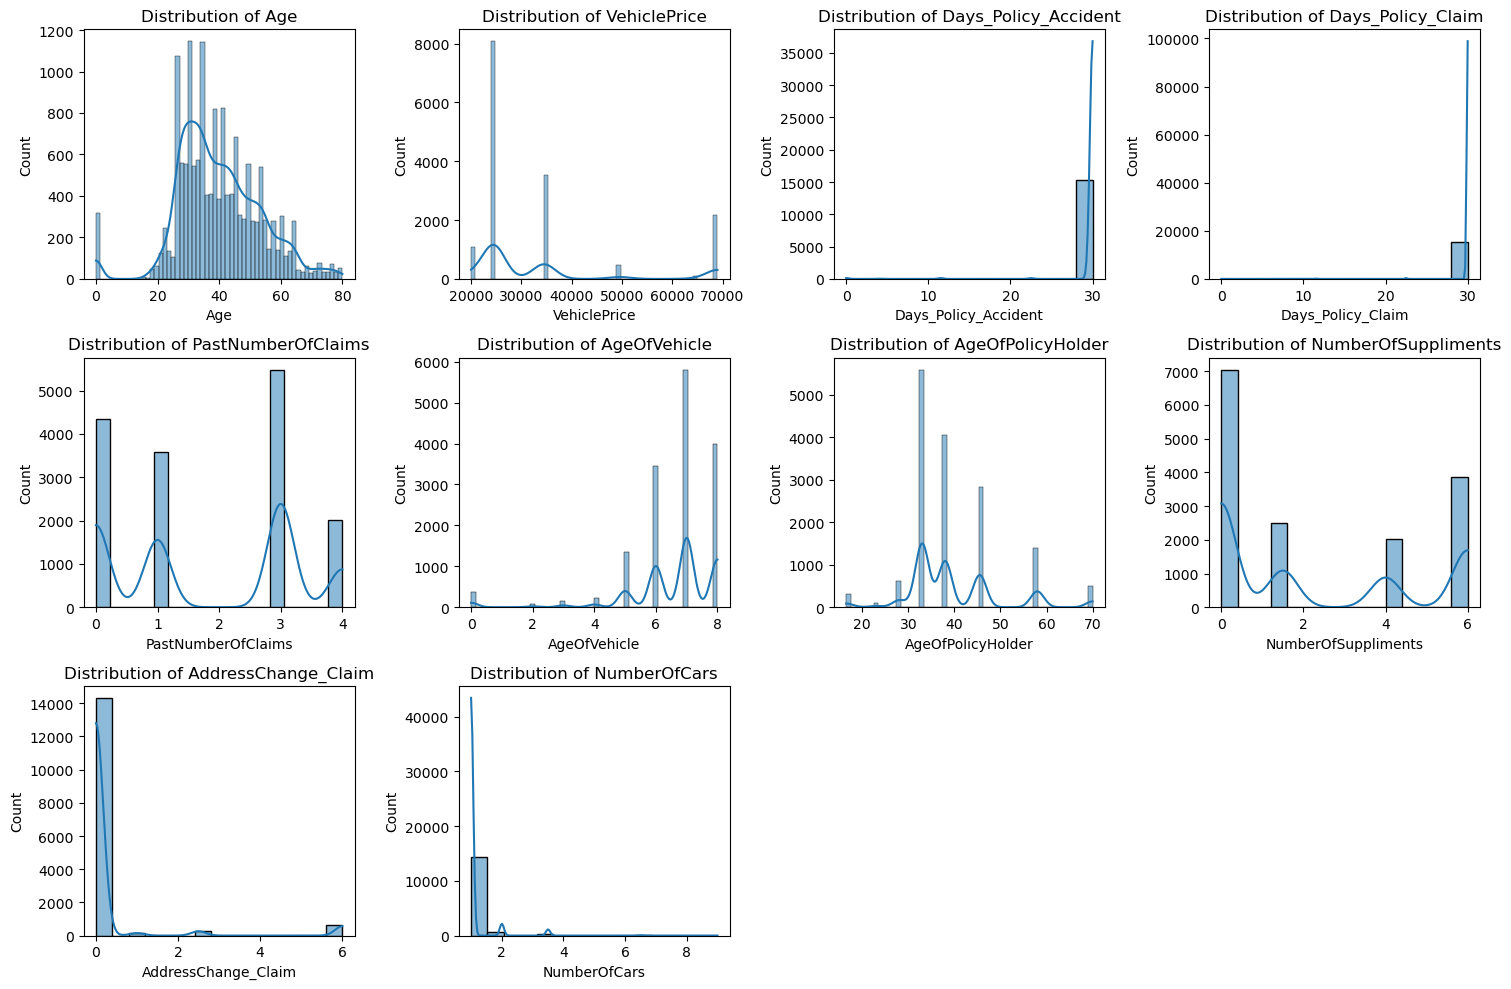

In [161]:
# Plot histograms for key numerical features
numerical_columns = ['Age', 'VehiclePrice', 'Days_Policy_Accident', 'Days_Policy_Claim', 
                     'PastNumberOfClaims', 'AgeOfVehicle', 'AgeOfPolicyHolder', 
                     'NumberOfSuppliments', 'AddressChange_Claim', 'NumberOfCars']

# Set up the plot grid
plt.figure(figsize=(15, 10))

for i, col in enumerate(numerical_columns, 1):
    plt.subplot(3, 4, i)  # Create a 3x4 grid for subplots
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

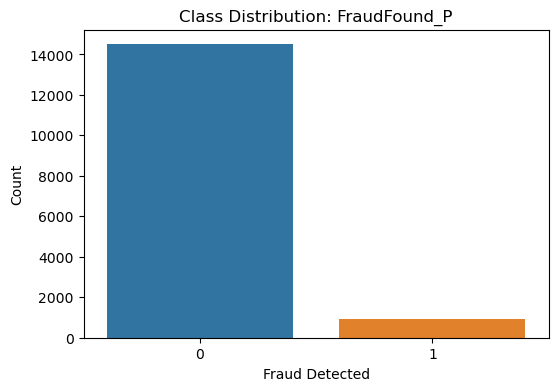

In [162]:
# Plot the distribution of the target variable (FraudFound_P)
plt.figure(figsize=(6, 4))
sns.countplot(x='FraudFound_P', data=df)
plt.title('Class Distribution: FraudFound_P')
plt.xlabel('Fraud Detected')
plt.ylabel('Count')
plt.show()

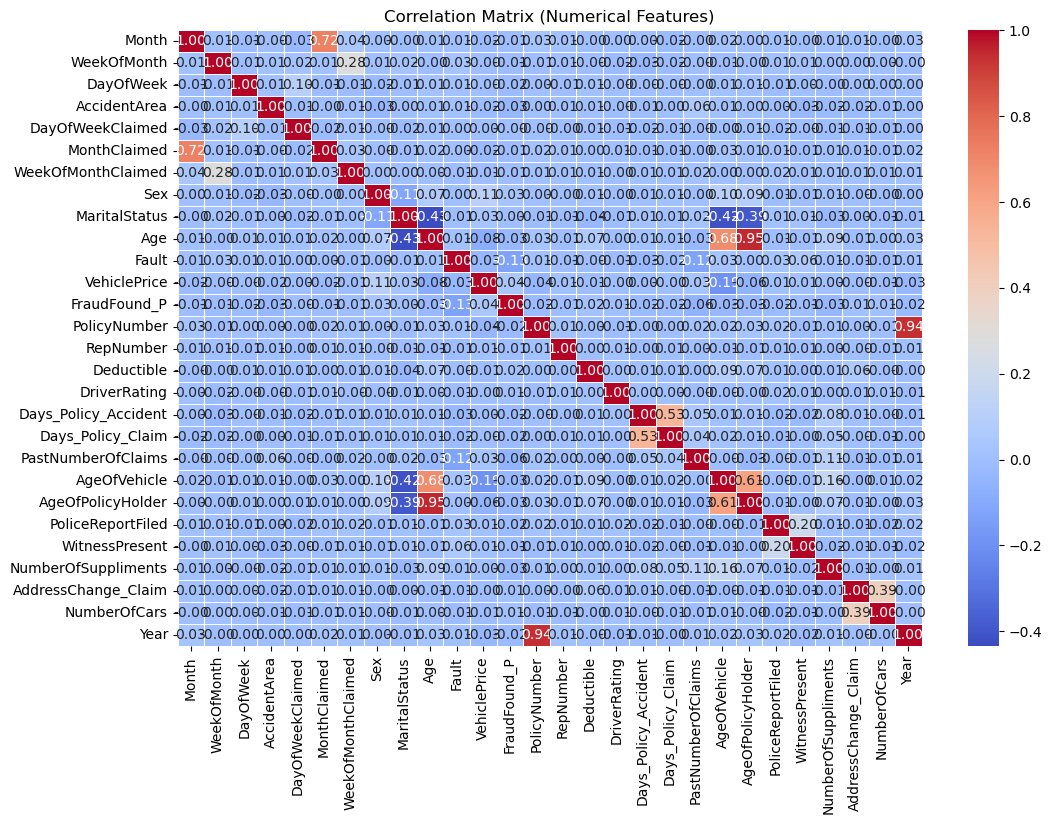

In [163]:
# Filter only numerical columns (int32, int64, float64) for correlation matrix
numerical_df = df.select_dtypes(include=['int32', 'int64', 'float64'])

# Compute the correlation matrix for numerical columns
corr_matrix = numerical_df.corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix (Numerical Features)')
plt.show()

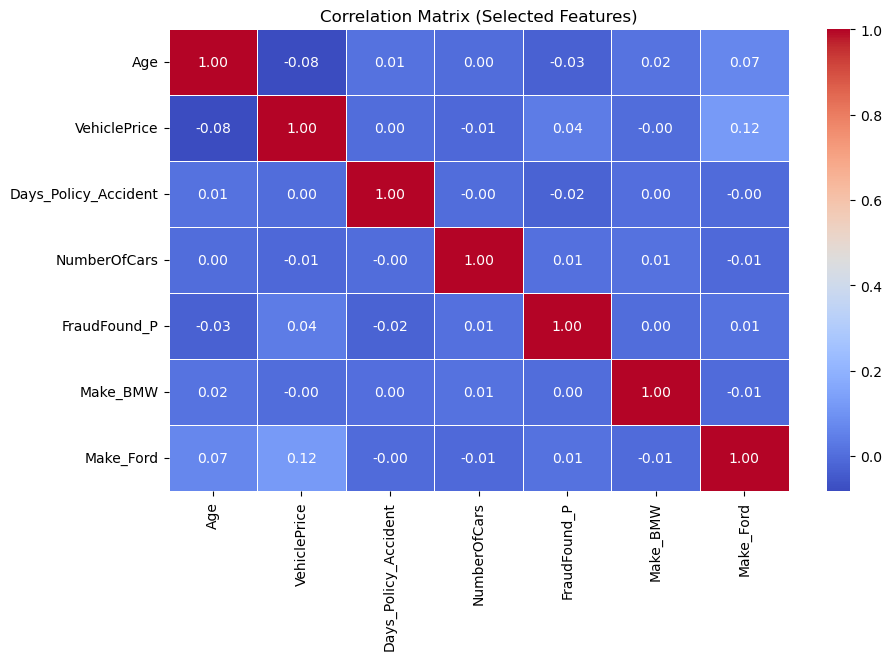

In [164]:
# Select numerical columns and some specific boolean columns to include
subset_df = df[['Age', 'VehiclePrice', 'Days_Policy_Accident', 'NumberOfCars', 'FraudFound_P', 
                'Make_BMW', 'Make_Ford']]

# Compute the correlation matrix for the selected subset
corr_matrix_subset = subset_df.corr()

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix_subset, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix (Selected Features)')
plt.show()

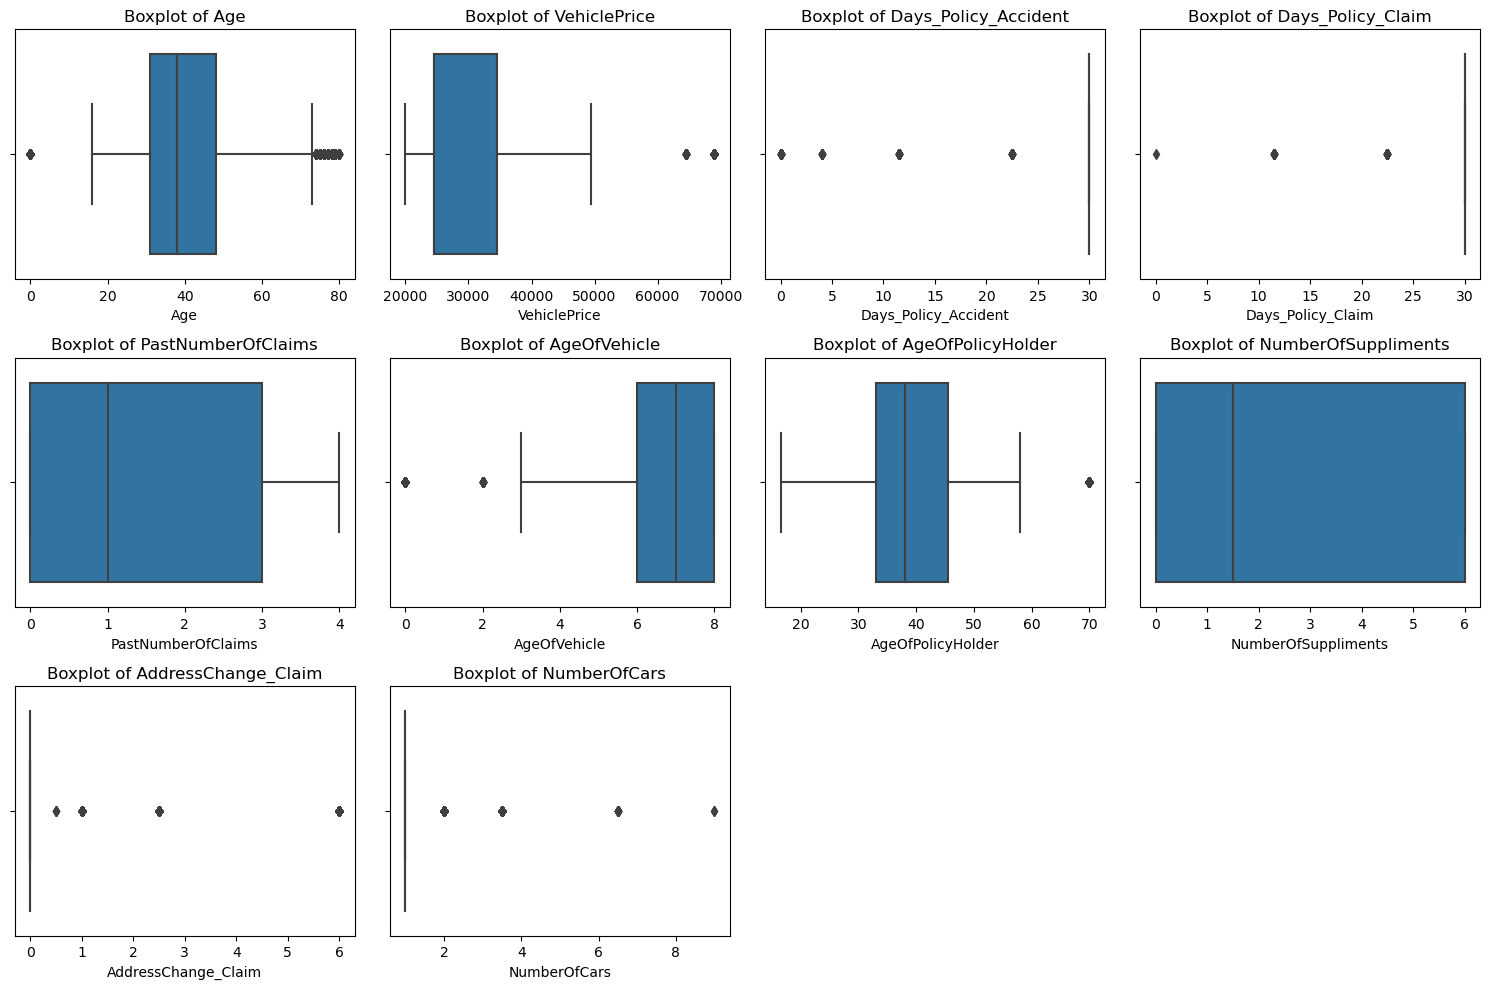

In [165]:
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_columns, 1):
    plt.subplot(3, 4, i)  # Create a 3x4 grid for subplots
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()

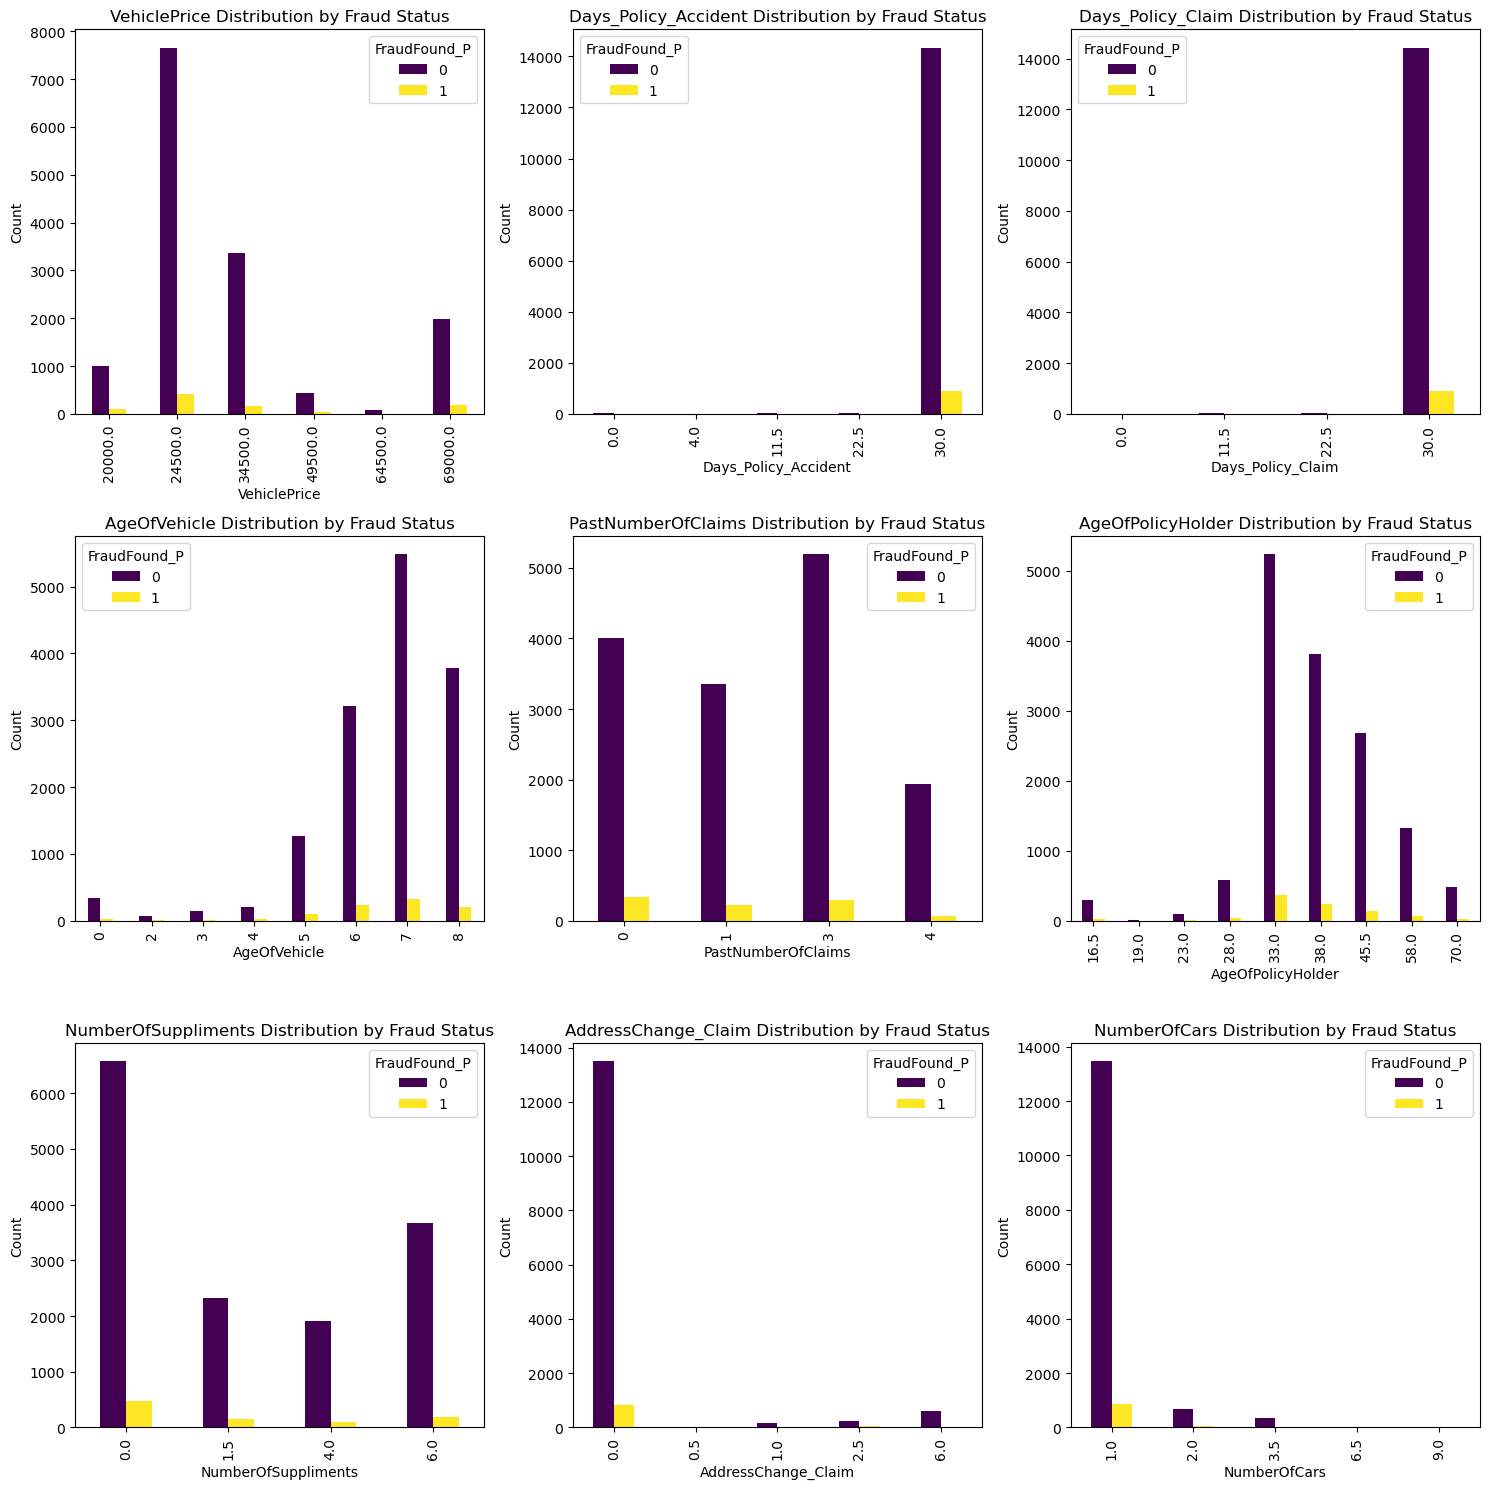

In [166]:
# List of range-based columns you want to plot, grouped by fraud
range_based_columns = ['VehiclePrice', 'Days_Policy_Accident', 'Days_Policy_Claim', 
                       'AgeOfVehicle', 'PastNumberOfClaims', 'AgeOfPolicyHolder', 
                       'NumberOfSuppliments', 'AddressChange_Claim', 'NumberOfCars']

# Set up the figure for multiple bar plots
plt.figure(figsize=(15, 15))

# Loop through each column and create a grouped bar plot by 'FraudFound_P'
for i, col in enumerate(range_based_columns, 1):
    plt.subplot(3, 3, i)  # Create a 3x3 grid for subplots
    
    # Create a grouped dataframe to show counts by fraud
    value_counts = df.groupby([col, 'FraudFound_P']).size().unstack().fillna(0)
    
    # Plot the bar graph for each column, split by 'FraudFound_P'
    value_counts.plot(kind='bar', ax=plt.gca(), stacked=False, colormap="viridis")

    # Set plot titles and labels
    plt.title(f'{col} Distribution by Fraud Status')
    plt.xlabel(col)
    plt.ylabel('Count')

plt.tight_layout()
plt.show()

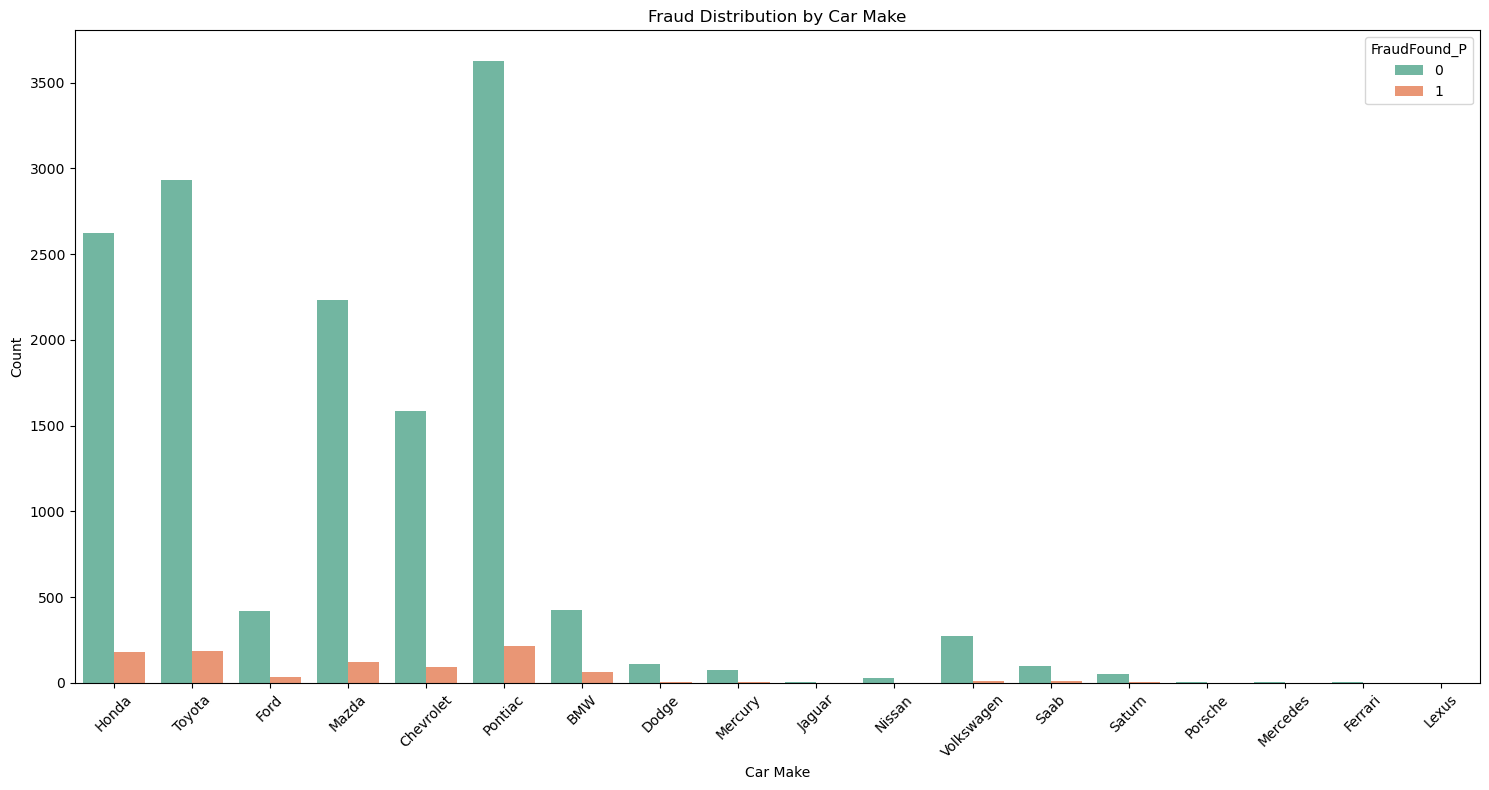

In [167]:
# Combine the one-hot encoded 'Make' columns into a single 'Make' column
df['Make'] = df[['Make_BMW', 'Make_Chevrolet', 'Make_Dodge', 'Make_Ferrari', 'Make_Ford', 
                 'Make_Honda', 'Make_Jaguar', 'Make_Lexus', 'Make_Mazda', 'Make_Mecedes', 
                 'Make_Mercury', 'Make_Nisson', 'Make_Pontiac', 'Make_Porche', 'Make_Saab', 
                 'Make_Saturn', 'Make_Toyota', 'Make_VW']].idxmax(axis=1)

# Replace the one-hot encoded column names with actual car makes
df['Make'] = df['Make'].replace({
    'Make_BMW': 'BMW', 
    'Make_Chevrolet': 'Chevrolet',
    'Make_Dodge': 'Dodge',
    'Make_Ferrari': 'Ferrari',
    'Make_Ford': 'Ford',
    'Make_Honda': 'Honda',
    'Make_Jaguar': 'Jaguar',
    'Make_Lexus': 'Lexus',
    'Make_Mazda': 'Mazda',
    'Make_Mecedes': 'Mercedes',
    'Make_Mercury': 'Mercury',
    'Make_Nisson': 'Nissan',
    'Make_Pontiac': 'Pontiac',
    'Make_Porche': 'Porsche',
    'Make_Saab': 'Saab',
    'Make_Saturn': 'Saturn',
    'Make_Toyota': 'Toyota',
    'Make_VW': 'Volkswagen'
})

# Plot grouped bar plot for fraud distribution across all makes
plt.figure(figsize=(15, 8))
sns.countplot(x='Make', hue='FraudFound_P', data=df, palette='Set2')

# Set title and labels
plt.title('Fraud Distribution by Car Make')
plt.xlabel('Car Make')
plt.ylabel('Count')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

In [168]:
df.shape

(15420, 51)

In [169]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15420 entries, 0 to 15419
Data columns (total 51 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Month                 15420 non-null  int32  
 1   WeekOfMonth           15420 non-null  int64  
 2   DayOfWeek             15420 non-null  int32  
 3   AccidentArea          15420 non-null  int32  
 4   DayOfWeekClaimed      15420 non-null  int32  
 5   MonthClaimed          15420 non-null  int32  
 6   WeekOfMonthClaimed    15420 non-null  int64  
 7   Sex                   15420 non-null  int32  
 8   MaritalStatus         15420 non-null  int32  
 9   Age                   15420 non-null  int64  
 10  Fault                 15420 non-null  int32  
 11  PolicyType            15420 non-null  object 
 12  VehicleCategory       15420 non-null  object 
 13  VehiclePrice          15420 non-null  float64
 14  FraudFound_P          15420 non-null  int64  
 15  PolicyNumber       

In [170]:
X = df[['Sex', 'MaritalStatus', 'Age', 'Fault', 'PolicyType', 'VehicleCategory', 
        'VehiclePrice', 'PolicyNumber', 'RepNumber', 
        'Days_Policy_Accident', 'Days_Policy_Claim', 'PastNumberOfClaims', 'AgeOfVehicle', 
        'AgeOfPolicyHolder', 'PoliceReportFiled', 'WitnessPresent', 'NumberOfCars', 'BasePolicy']]

# Target variable
y = df['FraudFound_P']

# Feature Engineering: Create 'Claim_Age_Ratio' and other binary features
X['Claim_Age_Ratio'] = X['AgeOfPolicyHolder'] / (X['PastNumberOfClaims'] + 1)
X['High_Claim_History'] = (X['PastNumberOfClaims'] > 2).astype(int)
X['Is_LuxuryVehicle'] = (X['VehiclePrice'] > 70000).astype(int)
X['Is_NewPolicyholder'] = (X['AgeOfPolicyHolder'] <= 1).astype(int)
X['Claims_Per_Year'] = X['PastNumberOfClaims'] / (X['AgeOfPolicyHolder'] + 1)

# List of numerical columns to scale (including engineered features)
numeric_columns = ['VehiclePrice', 'Age', 'Days_Policy_Accident', 'Days_Policy_Claim',
                   'PastNumberOfClaims', 'AgeOfVehicle', 'AgeOfPolicyHolder', 'Claim_Age_Ratio', 'Claims_Per_Year']

# Label Encoding for ordinal variables
le_vehiclecategory = LabelEncoder()
le_basepolicy = LabelEncoder()
le_policytype = LabelEncoder()

# Encode 'VehicleCategory', 'BasePolicy', 'PolicyType'
X['VehicleCategory'] = le_vehiclecategory.fit_transform(X['VehicleCategory'])
X['BasePolicy'] = le_basepolicy.fit_transform(X['BasePolicy'])
X['PolicyType'] = le_policytype.fit_transform(X['PolicyType'])

# One-hot encode columns that are categorical but not ordinal (if applicable)
one_hot_columns = ['Sex', 'MaritalStatus', 'Fault', 'PoliceReportFiled', 'WitnessPresent']
X = pd.get_dummies(X, columns=one_hot_columns, drop_first=True)  # One-hot encoding with drop_first=True to avoid multicollinearity

# Initialize the scaler for numerical columns
scaler = StandardScaler()

# Scale the numerical columns
X[numeric_columns] = scaler.fit_transform(X[numeric_columns])

# Drop 'PolicyNumber', 'RepNumber', and 'Year' if they're irrelevant
X = X.drop(columns=['PolicyNumber', 'RepNumber'])

# Perform the train-test split (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the shape of the final dataset
print(X_train.shape, X_test.shape)

(12336, 23) (3084, 23)


C:\Users\jimmy\AppData\Local\Temp\ipykernel_16252\3695739043.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Claim_Age_Ratio'] = X['AgeOfPolicyHolder'] / (X['PastNumberOfClaims'] + 1)
C:\Users\jimmy\AppData\Local\Temp\ipykernel_16252\3695739043.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['High_Claim_History'] = (X['PastNumberOfClaims'] > 2).astype(int)
C:\Users\jimmy\AppData\Local\Temp\ipykernel_16252\3695739043.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

In [173]:
# Split data before applying SMOTE
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize SMOTE
smote = SMOTE(random_state=42)

# Apply SMOTE to generate synthetic data for the minority class
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Check the new class distribution after SMOTE
from collections import Counter
print(f"Class distribution after SMOTE: {Counter(y_train_resampled)}")

Class distribution after SMOTE: Counter({0: 11610, 1: 11610})


In [174]:
# Combine X_train and y_train into one DataFrame
train_data = pd.concat([X_train, y_train], axis=1)

# Initialize and train the CTGAN model
ctgan_model = ctgan.CTGAN(epochs=300)  # Increase epochs for better generation
ctgan_model.fit(train_data, discrete_columns=['FraudFound_P'])  # Specify categorical columns

# Generate synthetic data (e.g., generate 5000 rows)
synthetic_data = ctgan_model.sample(5000)

# Separate the features and target from the synthetic data
X_synthetic = synthetic_data.drop('FraudFound_P', axis=1)
y_synthetic = synthetic_data['FraudFound_P']

In [175]:
# Combine the original resampled data from SMOTE with synthetic data from CTGAN
X_train_combined = pd.concat([X_train_resampled, X_synthetic], axis=0)
y_train_combined = pd.concat([y_train_resampled, y_synthetic], axis=0)

# Shuffle the combined data to mix synthetic and real samples
X_train_combined, y_train_combined = shuffle(X_train_combined, y_train_combined, random_state=42)

In [176]:
# Initialize XGBoost classifier
xgb_model = XGBClassifier(eval_metric='mlogloss')

# Train the model on the combined data (with SMOTE + CTGAN)
xgb_model.fit(X_train_combined, y_train_combined)

# Make predictions on the test data
y_pred = xgb_model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.9075875486381323
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.96      0.95      2887
           1       0.19      0.14      0.16       197

    accuracy                           0.91      3084
   macro avg       0.57      0.55      0.56      3084
weighted avg       0.89      0.91      0.90      3084

Confusion Matrix:
 [[2772  115]
 [ 170   27]]


In [177]:
# Step 1: Train the XGBoost model on the combined data (real + synthetic)
xgb_model = XGBClassifier(eval_metric='mlogloss', random_state=42)

# Fit the model on the combined training data (X_train_combined and y_train_combined include SMOTE + CTGAN data)
xgb_model.fit(X_train_combined, y_train_combined)

# Step 2: Make predictions on the real test data (X_test)
y_pred = xgb_model.predict(X_test)

# Evaluate the model on real test data
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Optional: Predict probabilities and set a custom threshold
y_proba = xgb_model.predict_proba(X_test)[:, 1]
custom_threshold = 0.5  # You can adjust this threshold based on what you observed
y_pred_custom = np.where(y_proba >= custom_threshold, 1, 0)

# Re-evaluate with the custom threshold
print(f"Classification Report at Threshold {custom_threshold}:\n", classification_report(y_test, y_pred_custom))
print(f"Confusion Matrix at Threshold {custom_threshold}:\n", confusion_matrix(y_test, y_pred_custom))

Accuracy: 0.9075875486381323
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.96      0.95      2887
           1       0.19      0.14      0.16       197

    accuracy                           0.91      3084
   macro avg       0.57      0.55      0.56      3084
weighted avg       0.89      0.91      0.90      3084

Confusion Matrix:
 [[2772  115]
 [ 170   27]]
Classification Report at Threshold 0.5:
               precision    recall  f1-score   support

           0       0.94      0.96      0.95      2887
           1       0.19      0.14      0.16       197

    accuracy                           0.91      3084
   macro avg       0.57      0.55      0.56      3084
weighted avg       0.89      0.91      0.90      3084

Confusion Matrix at Threshold 0.5:
 [[2772  115]
 [ 170   27]]


Threshold: 0.10 - Precision: 0.1320, Recall: 0.7665, F1-score: 0.2252
Threshold: 0.15 - Precision: 0.1439, Recall: 0.6701, F1-score: 0.2370
Threshold: 0.20 - Precision: 0.1486, Recall: 0.5787, F1-score: 0.2365
Threshold: 0.25 - Precision: 0.1535, Recall: 0.4822, F1-score: 0.2328
Threshold: 0.30 - Precision: 0.1613, Recall: 0.4061, F1-score: 0.2309
Threshold: 0.35 - Precision: 0.1723, Recall: 0.3350, F1-score: 0.2276
Threshold: 0.40 - Precision: 0.1869, Recall: 0.2741, F1-score: 0.2222
Threshold: 0.45 - Precision: 0.1745, Recall: 0.1878, F1-score: 0.1809
Threshold: 0.50 - Precision: 0.1901, Recall: 0.1371, F1-score: 0.1593
Threshold: 0.55 - Precision: 0.1720, Recall: 0.0812, F1-score: 0.1103
Threshold: 0.60 - Precision: 0.2188, Recall: 0.0711, F1-score: 0.1073
Threshold: 0.65 - Precision: 0.2195, Recall: 0.0457, F1-score: 0.0756
Threshold: 0.70 - Precision: 0.3103, Recall: 0.0457, F1-score: 0.0796
Threshold: 0.75 - Precision: 0.3636, Recall: 0.0406, F1-score: 0.0731
Threshold: 0.80 - Pr

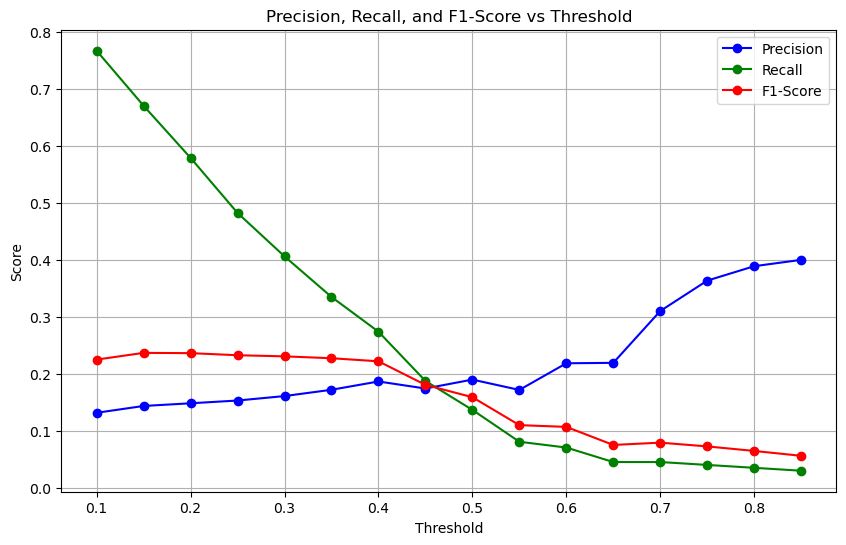


Best Threshold: 0.15000000000000002 with F1-Score: 0.236983842010772

Classification Report at Best Threshold:
              precision    recall  f1-score   support

           0       0.97      0.73      0.83      2887
           1       0.14      0.67      0.24       197

    accuracy                           0.72      3084
   macro avg       0.56      0.70      0.53      3084
weighted avg       0.92      0.72      0.79      3084

Confusion Matrix at Best Threshold:
[[2102  785]
 [  65  132]]


In [178]:
def apply_threshold(proba, threshold):
    return np.where(proba >= threshold, 1, 0)

# Step 4: Tune the threshold and evaluate precision, recall, and F1-score for each threshold
thresholds = np.arange(0.1, 0.9, 0.05)  # Define the range of thresholds to test
results = []

for threshold in thresholds:
    y_pred_custom = apply_threshold(y_proba, threshold)
    
    precision = precision_score(y_test, y_pred_custom)
    recall = recall_score(y_test, y_pred_custom)
    f1 = f1_score(y_test, y_pred_custom)
    
    # Save the results for plotting
    results.append((threshold, precision, recall, f1))
    
    # Print the metrics for each threshold
    print(f"Threshold: {threshold:.2f} - Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")

# Step 5: Convert the results to a NumPy array for easy indexing
results = np.array(results)

# Step 6: Plot Precision, Recall, and F1-Score vs Threshold
plt.figure(figsize=(10, 6))
plt.plot(results[:, 0], results[:, 1], marker='o', label='Precision', color='blue')
plt.plot(results[:, 0], results[:, 2], marker='o', label='Recall', color='green')
plt.plot(results[:, 0], results[:, 3], marker='o', label='F1-Score', color='red')

plt.title('Precision, Recall, and F1-Score vs Threshold')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()

# Step 7: Find and apply the best threshold based on F1-Score
best_threshold = results[np.argmax(results[:, 3]), 0]  # Max F1-score
best_f1 = np.max(results[:, 3])

print(f"\nBest Threshold: {best_threshold} with F1-Score: {best_f1}")
y_pred_best = apply_threshold(y_proba, best_threshold)

# Step 8: Final evaluation with the best threshold
print("\nClassification Report at Best Threshold:")
print(classification_report(y_test, y_pred_best))
print("Confusion Matrix at Best Threshold:")
print(confusion_matrix(y_test, y_pred_best))

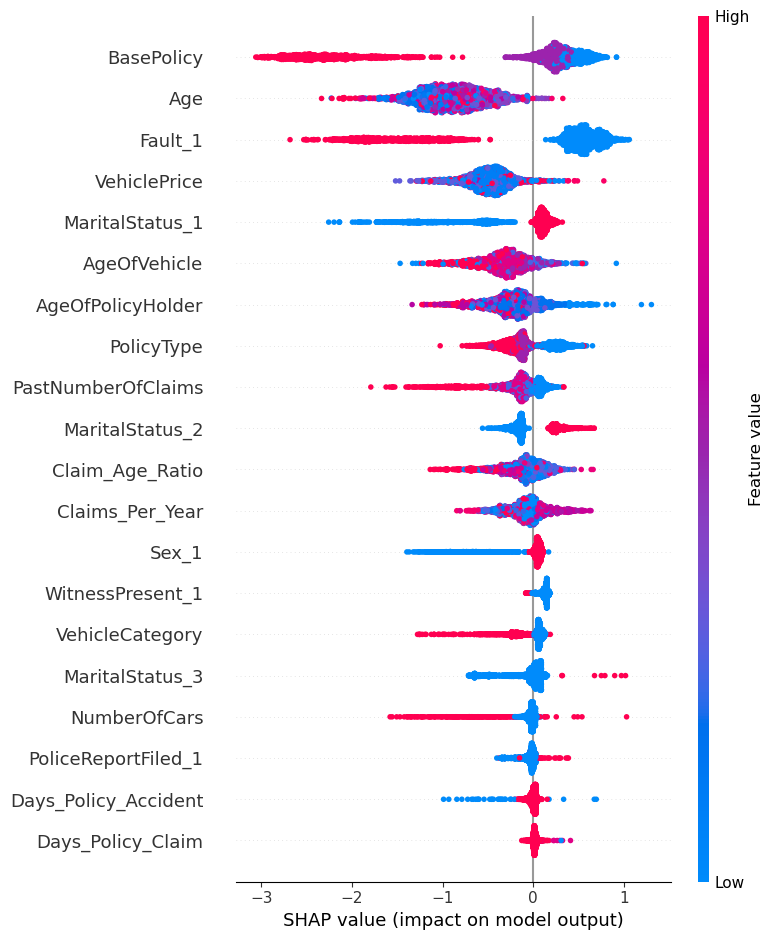

In [179]:
# Initialize SHAP explainer
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)

# Visualize SHAP values
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns)